In [31]:
"""
Subway Data Preprocessing Notebook

This notebook performs data cleaning, feature engineering, and aggregation of NYC subway data.
"""

'\nSubway Data Preprocessing Notebook\n\nThis notebook performs data cleaning, feature engineering, and aggregation of NYC subway data.\n'

In [32]:
import os
import sys
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from shapely import wkt


In [33]:
# Create spark session
spark = (
    SparkSession.builder.appName("Subway Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "America/New_York")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

### Read in data

In [ ]:
subway_data = None
subway_dir = "../data/landing/subway_data"
# Read all subway data
for year in sorted(os.listdir(subway_dir)):
    sdf = spark.read.parquet(os.path.join(subway_dir, year))
    if subway_data is None:
        subway_data = sdf
    else:
        subway_data = subway_data.unionByName(sdf)

subway_sdf = subway_data

### Check/convert data types

In [35]:
for line in subway_sdf.schema.fields:
    print(line.name, line.dataType)

transit_timestamp StringType()
transit_mode StringType()
station_complex_id StringType()
station_complex StringType()
borough StringType()
payment_method StringType()
fare_class_category StringType()
ridership IntegerType()
transfers IntegerType()
latitude DoubleType()
longitude DoubleType()
Georeference StringType()


In [36]:
# Only need to convert transit_timestamp
subway_sdf = subway_sdf.withColumn(
    "transit_timestamp", F.to_timestamp("transit_timestamp", "MM/dd/yyyy hh:mm:ss a")
)

In [37]:
subway_sdf.show(10)

+-------------------+------------+------------------+--------------------+---------+--------------+--------------------+---------+---------+---------+----------+--------------------+
|  transit_timestamp|transit_mode|station_complex_id|     station_complex|  borough|payment_method| fare_class_category|ridership|transfers| latitude| longitude|        Georeference|
+-------------------+------------+------------------+--------------------+---------+--------------+--------------------+---------+---------+---------+----------+--------------------+
|2024-09-01 10:00:00|      subway|               306|          125 St (1)|Manhattan|     metrocard|Metrocard - Fair ...|       13|        1|40.815582|-73.958374|POINT (-73.958374...|
|2024-09-01 10:00:00|      subway|               607|34 St-Herald Sq (...|Manhattan|     metrocard|Metrocard - Unlim...|       46|        0|40.749718| -73.98782|POINT (-73.98782 ...|
|2024-09-01 10:00:00|      subway|                50|        Avenue M (Q)| Brooklyn| 

### Create Lookup DataFrame

In [ ]:
# Create a lookup DataFrame for unique subway stations with coordinates, georeference, and name
lookup_cols = [
    "station_complex_id",
    "latitude",
    "longitude",
    "Georeference",
    "station_complex",
]

# Select distinct stations
station_lookup = (
    subway_sdf.select(*lookup_cols)
    .dropDuplicates(["station_complex_id"])
    .orderBy("station_complex_id")
)

os.makedirs("../data/curated/lookup", exist_ok=True)
# Output as CSV
station_lookup_pd = station_lookup.toPandas()
station_lookup_pd.to_csv("../data/curated/lookup/station_lookup.csv", index=False)

In [39]:
# Inspect lookup table
station_lookup.show(10, truncate=False)

+------------------+---------+----------+----------------------------+----------------------------------+
|station_complex_id|latitude |longitude |Georeference                |station_complex                   |
+------------------+---------+----------+----------------------------+----------------------------------+
|1                 |40.775036|-73.91203 |POINT (-73.91203 40.775036) |Astoria-Ditmars Blvd (N,W)        |
|10                |40.7599  |-73.98414 |POINT (-73.98414 40.7599)   |49 St (N,R,W)                     |
|100               |40.70687 |-73.95343 |POINT (-73.95343 40.70687)  |Hewes St (M,J)                    |
|101               |40.70836 |-73.957756|POINT (-73.957756 40.70836) |Marcy Av (M,J,Z)                  |
|103               |40.72028 |-73.99391 |POINT (-73.99391 40.72028)  |Bowery (J,Z)                      |
|107               |40.706474|-74.011055|POINT (-74.011055 40.706474)|Broad St (J,Z)                    |
|108               |40.711395|-73.8896  |POINT

In [ ]:
# Check georeference format and validity for the whole lookup table
def is_valid_wkt(val):
    try:
        wkt.loads(val)
        return True
    except Exception:
        return False


# Collect all Georeference values to driver
all_georefs = (
    station_lookup.select("Georeference")
    .rdd.map(lambda row: row["Georeference"])
    .collect()
)
# Check validity
validity = [is_valid_wkt(val) for val in all_georefs]
print(f"Valid WKT: {sum(validity)} / {len(validity)}")
if not all(validity):
    print("Invalid WKT found at indices:", [i for i, v in enumerate(validity) if not v])

Valid WKT: 428 / 428


### FIlter and drop data

In [41]:
subway_sdf.count()

27023937

In [42]:
# Filter transit mode to subway (research scope)
subway_sdf = subway_sdf.filter(subway_sdf["transit_mode"] == "subway")

subway_sdf.count()

26803065

In [43]:
subway_sdf.columns

['transit_timestamp',
 'transit_mode',
 'station_complex_id',
 'station_complex',
 'borough',
 'payment_method',
 'fare_class_category',
 'ridership',
 'transfers',
 'latitude',
 'longitude',
 'Georeference']

Drop columns not useful to analysis or out of scope (unrelated to taxi demand).

In [44]:
drop_list = [
    "transit_mode",
    "station_complex",
    "payment_method",
    "fare_class_category",
    "transfers",
]


# Drop each of these columns
for column in subway_sdf.columns:
    if col in drop_list:
        subway_sdf = subway_sdf.drop(column)


In [45]:
subway_sdf.count()

26803065

Look for nulls

In [ ]:
sys.path.append("../functions")
from processing import is_expected, report_null

# Check for null values in all features
report_null(subway_sdf, "Subway")


 Results for Subway


0


No nulls found

In [47]:
# Drop duplicates if any
subway_sdf = subway_sdf.dropDuplicates()

In [ ]:
subway_sdf.count()

26803065

25/08/29 15:24:43 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 4565244 ms exceeds timeout 120000 ms
25/08/29 15:24:43 WARN SparkContext: Killing executors is not supported by current scheduler.
25/08/29 15:25:07 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:669)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1296)
	at 

### Range Checking

In [29]:
# Expected ranges
# Bounds are set to except outliers but flag inaccurate data
expected_ranges = {
    "transit_timestamp": {
        "min": datetime(2024, 1, 1, 0, 0, 0),
        "max": datetime(2024, 12, 31, 23, 59, 59),
    },
    "station_complex_id": {"min": 1, "max": 9999},
    "borough": {
        "allowed_values": ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]
    },
    "ridership": {
        "min": 0,
        "max": 100000,  # Very high upper bound for one record
    },
    # From google maps NYC coords (extreme values)
    "latitude": {
        "min": 37,
        "max": 43,
    },
    "longitude": {"min": -77, "max": -71},
}


is_expected(subway_sdf, expected_ranges)


Column 'transit_timestamp': 56,349 Invalid values found.


Column 'station_complex_id': 0 Invalid values found.
Column 'borough': 0 Invalid values found.
Column 'ridership': 0 Invalid values found.
Column 'latitude': 0 Invalid values found.
Column 'longitude': 0 Invalid values found.


({'transit_timestamp': 56349,
  'station_complex_id': 0,
  'borough': 0,
  'ridership': 0,
  'latitude': 0,
  'longitude': 0},
 Column<'or(or(or(or(or(or(<(transit_timestamp, 2024-01-01 00:00:00.0), >(transit_timestamp, 2024-12-31 23:59:59.0)), or(<(station_complex_id, 1), >(station_complex_id, 9999))), !(in(borough, 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'))), or(<(ridership, 0), >(ridership, 100000))), or(<(latitude, 37), >(latitude, 43))), or(<(longitude, -77), >(longitude, -71)))'>)

In [ ]:
min_time = datetime(2024, 1, 1, 0, 0, 0)
max_time = datetime(2024, 12, 31, 23, 59, 59)

# Show any rows outside the full expected range
subway_sdf.filter(
    (F.col("transit_timestamp") < F.lit(min_time))
    | (F.col("transit_timestamp") > F.lit(max_time))
).show(10, truncate=False)

+-------------------+------------+------------------+----------------------------------+---------+--------------+----------------------------+---------+---------+---------+----------+----------------------------+
|transit_timestamp  |transit_mode|station_complex_id|station_complex                   |borough  |payment_method|fare_class_category         |ridership|transfers|latitude |longitude |Georeference                |
+-------------------+------------+------------------+----------------------------------+---------+--------------+----------------------------+---------+---------+---------+----------+----------------------------+
|2024-12-31 08:00:00|subway      |32                |36 St (D,N,R)                     |Brooklyn |metrocard     |Metrocard - Unlimited 30-Day|41       |0        |40.655144|-74.00355 |POINT (-74.00355 40.655144) |
|2024-12-31 08:00:00|subway      |325               |Canal St (1)                      |Manhattan|metrocard     |Metrocard - Unlimited 7-Day |11    

These are all 2024, just a spark mismatch so we will keep them

In [18]:
subway_sdf.count()

26803065

In [19]:
# Remove the values with year != 2024
subway_sdf = subway_sdf.filter(F.year("transit_timestamp") == 2024)

In [20]:
subway_sdf.count()

26803065

These were all just Spark timezone mismatches in 2024 so we will keep them.

### Outlier Analysis

Less likely to remove outliers here as the data is already aggregated. Outliers here are likely to be true spikes, let's inspect the distribution first and see.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

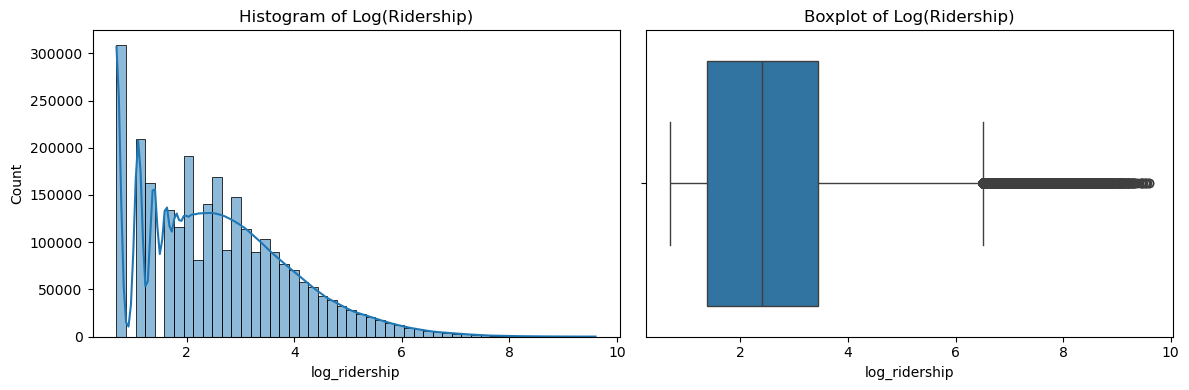

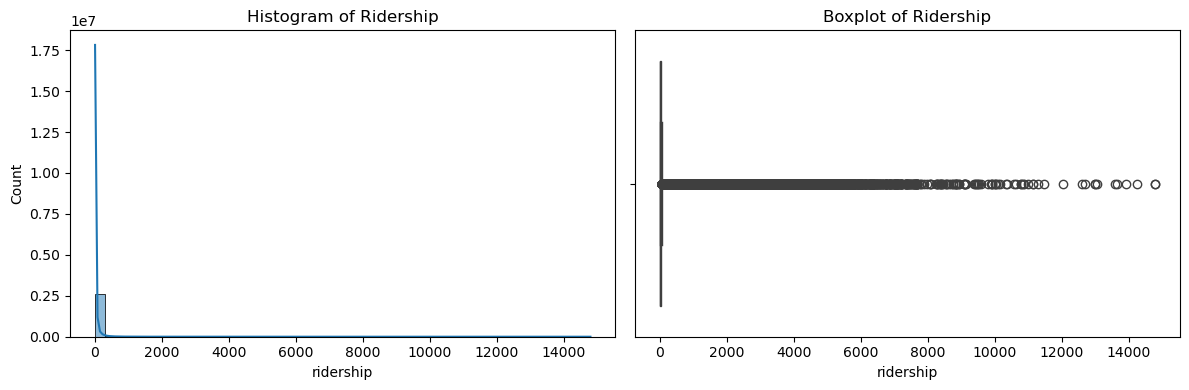

In [ ]:
# Inspect the distribution of hourly ridership

# Sample a fraction of the data for plotting
sample_pd = subway_sdf.select("ridership").sample(fraction=0.1, seed=1462474).toPandas()

# Take log (add 1 to avoid log(0))
sample_pd["log_ridership"] = np.log1p(sample_pd["ridership"])

# Plot the log ridership distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(sample_pd["log_ridership"], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Histogram of Log(Ridership)")
sns.boxplot(x=sample_pd["log_ridership"], ax=axes[1])
axes[1].set_title("Boxplot of Log(Ridership)")
plt.tight_layout()
plt.show()

# Plot the ridership distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(sample_pd["ridership"], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Histogram of Ridership")
sns.boxplot(x=sample_pd["ridership"], ax=axes[1])
axes[1].set_title("Boxplot of Ridership")
plt.tight_layout()
plt.show()


14000-15000 is high but still realistic for a busy station. We shall keep these outliers, we don't want to introduce bias towards smaller stations. Also we want a saturated grid to join with taxi on.

### Aggregation

Need to aggregate to station by hour, as there are multiple records for a single station at a single time.
Here we aggregate before range checking as we seek to only use the aggregated data as a representation for demand.

In [ ]:
# Ensure timestamp is in TimestampType
subway_sdf = subway_sdf.withColumn(
    "transit_timestamp", F.to_timestamp("transit_timestamp")
)

# Hourly ridership (sum per stationid per hour)
hourly_sdf = (
    subway_sdf.groupBy(
        "station_complex_id",
        F.window("transit_timestamp", "1 hour").alias("hour_window"),
    )
    # Aggregate ridership and other features
    .agg(
        F.sum("ridership").alias("hourly_ridership"),
        F.first("borough").alias("borough"),
        F.first("latitude").alias("latitude"),
        F.first("longitude").alias("longitude"),
        F.first("Georeference").alias("georeference"),
    )
    .withColumn("hour", F.col("hour_window").start)
    .drop("hour_window")
)

In [24]:
hourly_sdf.count()

3649615

In [ ]:
# Check aggregation worked as intended (should be same as sdf count)
subway_sdf.select("station_complex_id", "transit_timestamp").distinct().count()

3649615

Aggregation did not lose any records

### Save Curated Data

In [27]:
output = "../data/curated/subway_data"
# Create folder
os.makedirs(output, exist_ok=True)
hourly_sdf.write.mode("overwrite").parquet(output)

In [28]:
# End spark sessions
spark.stop()